Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [353]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in `1_notmnist.ipynb`.

In [16]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [351]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 1 to [0.0, 1.0, 0.0 ...], 2 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
X_train, Y_train = reformat(train_dataset, train_labels)
X_dev, Y_dev = reformat(valid_dataset, valid_labels)
X_test, Y_test = reformat(test_dataset, test_labels)
print('Training set', X_train.shape, Y_train.shape)
print('Development set', X_dev.shape, Y_dev.shape)
print('Test set', X_test.shape, Y_test.shape)

Training set (200000, 784) (200000, 10)
Development set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [308]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [313]:
# L2 regularization for logistic model - Graph setup

batch_size = 128   # Batch size for SGD
learning_rate = 0.5   # Learning rate
lambd = 0.0001   # Regularization factor 0.0001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  Xt = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
  Yt = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
  Xd = tf.constant(X_dev)
  Xs = tf.constant(X_test)

  # Variables.
  W = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  b = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  Zt = tf.matmul(Xt, W) + b
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Yt, logits = Zt))
  l2_cost = lambd * tf.nn.l2_loss(W)
  cost = cost + l2_cost

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
  
  # Predictions for the training, validation, and test data.
  Yt_hat = tf.nn.softmax(Zt)
  Yd_hat = tf.nn.softmax(tf.matmul(Xd, W) + b)
  Ys_hat = tf.nn.softmax(tf.matmul(Xs, W) + b)

In [314]:
# L2 regularization for logistic model - Running graph

num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = X_train[offset:(offset + batch_size), :]
    batch_labels = Y_train[offset:(offset + batch_size), :]
    # Run step
    _, batch_cost_val, Yt_hat_val = session.run([optimizer, cost, Yt_hat], feed_dict = {Xt : batch_data, Yt : batch_labels})
    if (step % 500 == 0):
      print("Minibatch cost at step %d: %f" % (step, batch_cost_val))
      print("Minibatch accuracy: %.1f%%" % accuracy(Yt_hat_val, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(Yd_hat.eval(), Y_dev))
  print("Test accuracy: %.1f%%" % accuracy(Ys_hat.eval(), Y_test))

Initialized
Minibatch cost at step 0: 16.785881
Minibatch accuracy: 6.2%
Validation accuracy: 16.8%
Minibatch cost at step 500: 2.288350
Minibatch accuracy: 71.1%
Validation accuracy: 75.6%
Minibatch cost at step 1000: 1.466214
Minibatch accuracy: 75.0%
Validation accuracy: 77.0%
Minibatch cost at step 1500: 1.541365
Minibatch accuracy: 77.3%
Validation accuracy: 78.1%
Minibatch cost at step 2000: 0.996936
Minibatch accuracy: 81.2%
Validation accuracy: 77.4%
Minibatch cost at step 2500: 1.333328
Minibatch accuracy: 77.3%
Validation accuracy: 79.3%
Minibatch cost at step 3000: 0.961329
Minibatch accuracy: 80.5%
Validation accuracy: 79.6%
Minibatch cost at step 3500: 0.613429
Minibatch accuracy: 86.7%
Validation accuracy: 79.5%
Minibatch cost at step 4000: 1.190817
Minibatch accuracy: 75.0%
Validation accuracy: 80.4%
Minibatch cost at step 4500: 0.725675
Minibatch accuracy: 83.6%
Validation accuracy: 80.7%
Minibatch cost at step 5000: 0.574037
Minibatch accuracy: 85.2%
Validation accurac

---
Now, let's try a neural network model.
First, let's define some helper functions to create and run an L-layer neural network model

---

In [366]:
def random_minibatches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, input size)
    Y -- output data aka true "label" vector, of shape (number of examples, output size)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            # to get consistent results
    m = X.shape[0]                  # number of examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in the partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : (k+1) * mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size :, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size :, : ]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [367]:
# Try random_minibatches function 

minibatches = random_minibatches(X_train, Y_train, 128)

print ("shape of the 1st minibatch_X: " + str(minibatches[0][0].shape))
print ("shape of the 2nd minibatch_X: " + str(minibatches[1][0].shape))
print ("shape of the 3rd minibatch_X: " + str(minibatches[2][0].shape))
print ("shape of the last minibatch_X: " + str(minibatches[-1][0].shape))
print ("shape of the 1st minibatch_Y: " + str(minibatches[0][1].shape))
print ("shape of the 2nd minibatch_Y: " + str(minibatches[1][1].shape)) 
print ("shape of the 3rd minibatch_Y: " + str(minibatches[2][1].shape))
print ("shape of the last minibatch_Y: " + str(minibatches[-1][1].shape))

shape of the 1st minibatch_X: (128, 784)
shape of the 2nd minibatch_X: (128, 784)
shape of the 3rd minibatch_X: (128, 784)
shape of the last minibatch_X: (64, 784)
shape of the 1st minibatch_Y: (128, 10)
shape of the 2nd minibatch_Y: (128, 10)
shape of the 3rd minibatch_Y: (128, 10)
shape of the last minibatch_Y: (64, 10)


In [315]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session
    
    Arguments:
    n_x -- scalar, size of input vector
    n_y -- scalar, size of output vector aka number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape (None, n_x) and dtype "float"
    Y -- placeholder for the input labels, of shape (None, n_y) and dtype "float"
    
    Note:
    - We will use None because it let's us be flexible on the number of examples you will for the placeholders
    """

    X = tf.placeholder(tf.float32, shape = [None, n_x], name = 'X')
    Y = tf.placeholder(tf.float32, shape = [None, n_y], name = 'Y')
    
    return X, Y

In [316]:
# Try create_placeholders function 

tf.reset_default_graph()
X, Y = create_placeholders(12288, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 12288), dtype=float32)
Y = Tensor("Y:0", shape=(?, 6), dtype=float32)


In [317]:
def initialize_parameters(layer_dims):
    """
    Initializes parameters to build a neural network with tensorflow
    
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    variables -- python dictionary containing tensors "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (layer_dims[l],)
    """
    
    tf.set_random_seed(1)                   # so to keep consistent results
        
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = tf.Variable(tf.truncated_normal([layer_dims[l-1], layer_dims[l]]), name = 'W' + str(l))
        parameters['b' + str(l)] = tf.Variable(tf.zeros([layer_dims[l]]), name = 'b' + str(l))
        
        assert(parameters['W' + str(l)].get_shape().as_list() == [layer_dims[l-1], layer_dims[l]])
        assert(parameters['b' + str(l)].get_shape().as_list() == [layer_dims[l]])

    return parameters  

In [318]:
# Try initialize_parameters function

tf.reset_default_graph()
parameters = initialize_parameters([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = Tensor("W1/read:0", shape=(5, 4), dtype=float32)
b1 = Tensor("b1/read:0", shape=(4,), dtype=float32)
W2 = Tensor("W2/read:0", shape=(4, 3), dtype=float32)
b2 = Tensor("b2/read:0", shape=(3,), dtype=float32)


In [319]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model
    
    Arguments:
    X -- input dataset placeholder, of shape (number of examples, input size)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z -- the output of the last LINEAR unit
    """
    
    L = len(parameters) // 2
    A = X
    
    for l in range(1, L):
      Z = tf.add(tf.matmul(A, parameters['W' + str(l)]), parameters['b' + str(l)])
      A = tf.nn.relu(Z)
    
    Z = tf.add(tf.matmul(A, parameters['W' + str(L)]), parameters['b' + str(L)])

    return Z

In [320]:
# Try forward_propagation function

tf.reset_default_graph()
n_x = 12228
n_y = 6
with tf.Session() as sess:
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters([n_x, 30, 10, n_y])
    Z = forward_propagation(X, parameters)
    print("Z = " + str(Z))

Z = Tensor("Add_2:0", shape=(?, 6), dtype=float32)


In [321]:
def compute_cost(Z, Y):
    """
    Computes the cost
    
    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, output size)
    Y -- "true" labels vector placeholder, same shape as Z
    
    Returns:
    cost - Tensor of the cost function
    """
      
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    
    return cost

In [299]:
# Try compute_cost function

tf.reset_default_graph()
n_x = 12288
n_y = 6
with tf.Session() as sess:
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters([n_x, 30, 10, n_y])
    Z = forward_propagation(X, parameters)
    cost = compute_cost(Z, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


In [397]:
def dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, layer_dims, learning_rate = 0.5,
          num_epochs = 101, minibatch_size = 128, print_cost = True):
    """
    Implements and trains a N-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->...->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- train set, of shape (m, n_x)
    Y_train -- train labels, of shape (m, n_y)
    X_dev -- dev set, of shape (m_dev, n_x)
    Y_dev -- dev labels, of shape (m_dev, n_y)    
    X_test -- test set, of shape (m_test, n_x)
    Y_test -- test labels, of shape (m_test, n_y)
    layer_dims -- python array (list) containing the dimensions of each layer in our network 
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    m = X_train.shape[0]                              # m : number of examples in the train set)
    n_x, n_y = layer_dims[0], layer_dims[-1]          # n_x: input size, n_y : output size
    num_minibatches = int(m / minibatch_size)         # number of minibatches of size minibatch_size in the train set
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y) for training data batches 
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters)
    
    # Predictions: Add predictions to tensorflow graph
    Y_hat = tf.nn.softmax(Z)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use a GradientDescentOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        batch_cost = 0
        n_minibatch = 0
        
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0.                           # Defines a cost related to an epoch
            seed = seed + 1
            minibatches = random_minibatches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run step
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y})
                # Add minibatch cost to epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                            
            # Print the cost, train accuracy and dev accuracy every 100 minibatches
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate accuracy on the train, dev and test sets
        print("Train accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_train}), Y_train))
        print("Dev accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_dev}), Y_dev))
        print("Test accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_test}), Y_test))
      
    return parameters

Cost after epoch 0: 21.551738
Cost after epoch 1: 5.194298
Cost after epoch 2: 3.199275
Cost after epoch 3: 2.287248
Cost after epoch 4: 1.755237
Cost after epoch 5: 1.388625
Cost after epoch 6: 1.197134
Cost after epoch 7: 0.980969
Cost after epoch 8: 0.837027
Cost after epoch 9: 0.722353


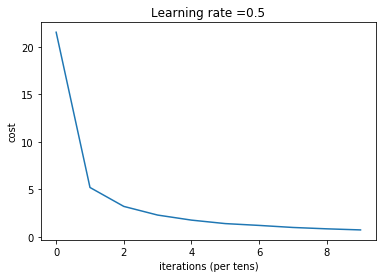

Parameters have been trained!
Train accuracy: 89.1%
Dev accuracy: 83.6%
Test accuracy: 90.2%


In [382]:
# Let's start with suggested architecture and parameters: 2 layer nn model, 1024 hidden nodes, 10 epochs, minibatch size of 128 examples

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 10, minibatch_size = 128, print_cost = True)

Note: From the much higher train accuracy than dev accuracy it seems we are overfitting

Cost after epoch 0: 10.730956
Cost after epoch 1: 2.767239
Cost after epoch 2: 1.815728
Cost after epoch 3: 1.387284
Cost after epoch 4: 1.112699
Cost after epoch 5: 0.940918
Cost after epoch 6: 0.826081
Cost after epoch 7: 0.748193
Cost after epoch 8: 0.683355
Cost after epoch 9: 0.626883


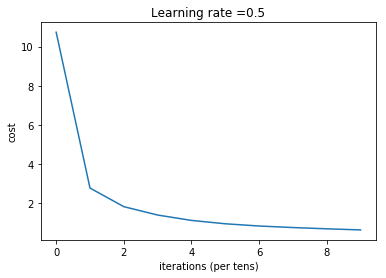

Parameters have been trained!
Train accuracy: 86.8%
Dev accuracy: 83.5%
Test accuracy: 90.5%


In [383]:
# Let's try now a smaller nn, with 512 hidden nodes

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 512, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 10, minibatch_size = 128, print_cost = True)

Note: Train accuracy decreased, while dev accuracy and test accuracy did not change, keeping the same generalization power

Cost after epoch 0: 1.383672
Cost after epoch 1: 0.819415
Cost after epoch 2: 0.739020
Cost after epoch 3: 0.685040
Cost after epoch 4: 0.647484
Cost after epoch 5: 0.627352
Cost after epoch 6: 0.605498
Cost after epoch 7: 0.589485
Cost after epoch 8: 0.577407
Cost after epoch 9: 0.565940
Cost after epoch 10: 0.555283
Cost after epoch 11: 0.544711
Cost after epoch 12: 0.537813
Cost after epoch 13: 0.529557
Cost after epoch 14: 0.523125
Cost after epoch 15: 0.517912
Cost after epoch 16: 0.512357
Cost after epoch 17: 0.508426
Cost after epoch 18: 0.503596
Cost after epoch 19: 0.499364
Cost after epoch 20: 0.494259
Cost after epoch 21: 0.490642
Cost after epoch 22: 0.487888
Cost after epoch 23: 0.484528
Cost after epoch 24: 0.480750
Cost after epoch 25: 0.477680
Cost after epoch 26: 0.474168
Cost after epoch 27: 0.471827
Cost after epoch 28: 0.469054
Cost after epoch 29: 0.466784
Cost after epoch 30: 0.464129
Cost after epoch 31: 0.462066
Cost after epoch 32: 0.459952
Cost after epoch 33:

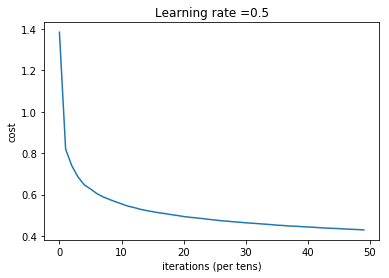

Parameters have been trained!
Train accuracy: 87.4%
Dev accuracy: 86.1%
Test accuracy: 92.2%


In [395]:
# Let's try now a smaller nn, with 32 hidden nodes, and longer training to ensure good fitting

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 32, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 50, minibatch_size = 128, print_cost = True)

Note: Train accuracy slightly increased and dev accuracy too, roughly at the same level, suggesting good generalization. But train accuracy worse than for nn with 1024 nodes, indicating the current nn is underfitting the train data

Cost after epoch 0: 1.937023
Cost after epoch 1: 0.896471
Cost after epoch 2: 0.772267
Cost after epoch 3: 0.708626
Cost after epoch 4: 0.663766
Cost after epoch 5: 0.634799
Cost after epoch 6: 0.610056
Cost after epoch 7: 0.591140
Cost after epoch 8: 0.572960
Cost after epoch 9: 0.560754
Cost after epoch 10: 0.547978
Cost after epoch 11: 0.535379
Cost after epoch 12: 0.525649
Cost after epoch 13: 0.515801
Cost after epoch 14: 0.507126
Cost after epoch 15: 0.500170
Cost after epoch 16: 0.492982
Cost after epoch 17: 0.486421
Cost after epoch 18: 0.479643
Cost after epoch 19: 0.474043
Cost after epoch 20: 0.468987
Cost after epoch 21: 0.463165
Cost after epoch 22: 0.458661
Cost after epoch 23: 0.454372
Cost after epoch 24: 0.449544
Cost after epoch 25: 0.446021
Cost after epoch 26: 0.442316
Cost after epoch 27: 0.437580
Cost after epoch 28: 0.434186
Cost after epoch 29: 0.431101
Cost after epoch 30: 0.426939
Cost after epoch 31: 0.424394
Cost after epoch 32: 0.420992
Cost after epoch 33:

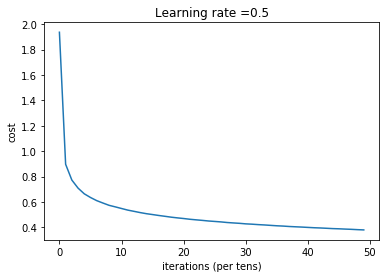

Parameters have been trained!
Train accuracy: 88.9%
Dev accuracy: 86.7%
Test accuracy: 93.0%


In [396]:
# Let's try now a bigger nn, with 64 hidden nodes, same training

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 64, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 50, minibatch_size = 128, print_cost = True)

Note: Train accuracy slightly increased and dev accuracy too, with a wider gap now, suggesting slightly worse generalization

Cost after epoch 0: 1.937023
Cost after epoch 1: 0.896471
Cost after epoch 2: 0.772267
Cost after epoch 3: 0.708626
Cost after epoch 4: 0.663766
Cost after epoch 5: 0.634799
Cost after epoch 6: 0.610056
Cost after epoch 7: 0.591140
Cost after epoch 8: 0.572960
Cost after epoch 9: 0.560754
Cost after epoch 10: 0.547978
Cost after epoch 11: 0.535379
Cost after epoch 12: 0.525649
Cost after epoch 13: 0.515801
Cost after epoch 14: 0.507126
Cost after epoch 15: 0.500170
Cost after epoch 16: 0.492982
Cost after epoch 17: 0.486421
Cost after epoch 18: 0.479643
Cost after epoch 19: 0.474043
Cost after epoch 20: 0.468987
Cost after epoch 21: 0.463165
Cost after epoch 22: 0.458661
Cost after epoch 23: 0.454372
Cost after epoch 24: 0.449544
Cost after epoch 25: 0.446021
Cost after epoch 26: 0.442316
Cost after epoch 27: 0.437580
Cost after epoch 28: 0.434186
Cost after epoch 29: 0.431101
Cost after epoch 30: 0.426939
Cost after epoch 31: 0.424394
Cost after epoch 32: 0.420992
Cost after epoch 33:

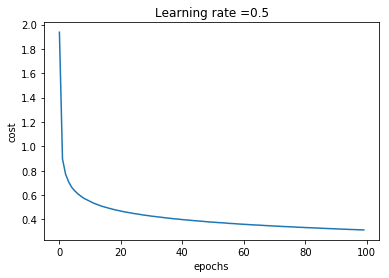

Parameters have been trained!
Train accuracy: 90.4%
Dev accuracy: 86.7%
Test accuracy: 92.8%


In [502]:
# Let's keep the same nn, but train it longer (50 -> 100 epochs)

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 64, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: Train accuracy increased while dev accuracy did not change, widening the gap between them. This indicates worse generalization and overfitting

Cost after epoch 0: 3.119677
Cost after epoch 1: 1.080859
Cost after epoch 2: 0.862111
Cost after epoch 3: 0.759122
Cost after epoch 4: 0.691599
Cost after epoch 5: 0.652735
Cost after epoch 6: 0.622093
Cost after epoch 7: 0.593145
Cost after epoch 8: 0.572894
Cost after epoch 9: 0.557711
Cost after epoch 10: 0.540436
Cost after epoch 11: 0.526198
Cost after epoch 12: 0.513652
Cost after epoch 13: 0.503061
Cost after epoch 14: 0.492580
Cost after epoch 15: 0.483578
Cost after epoch 16: 0.474524
Cost after epoch 17: 0.466276
Cost after epoch 18: 0.458571
Cost after epoch 19: 0.450817
Cost after epoch 20: 0.444414
Cost after epoch 21: 0.437631
Cost after epoch 22: 0.431279
Cost after epoch 23: 0.425445
Cost after epoch 24: 0.420338
Cost after epoch 25: 0.414106
Cost after epoch 26: 0.409407
Cost after epoch 27: 0.403904
Cost after epoch 28: 0.399169
Cost after epoch 29: 0.394628
Cost after epoch 30: 0.389673
Cost after epoch 31: 0.385054
Cost after epoch 32: 0.381582
Cost after epoch 33:

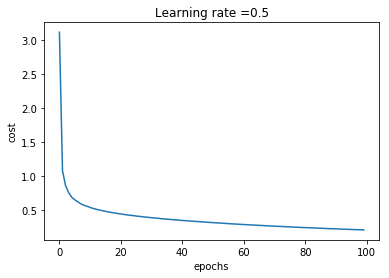

Parameters have been trained!
Train accuracy: 93.9%
Dev accuracy: 86.8%
Test accuracy: 92.8%


In [402]:
# Let's try now a bigger nn, with 128 hidden nodes, same training

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 128, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: Train accuracy increased while dev accuracy did not change, widening the gap between them. This indicates worse generalization and overfitting

Cost after epoch 0: 1.801926
Cost after epoch 1: 1.099042
Cost after epoch 2: 0.823049
Cost after epoch 3: 0.714576
Cost after epoch 4: 0.673072
Cost after epoch 5: 0.638758
Cost after epoch 6: 0.622359
Cost after epoch 7: 0.610214
Cost after epoch 8: 0.614193
Cost after epoch 9: 0.593104
Cost after epoch 10: 0.565432
Cost after epoch 11: 0.561413
Cost after epoch 12: 0.553939
Cost after epoch 13: 0.547320
Cost after epoch 14: 0.541471
Cost after epoch 15: 0.545095
Cost after epoch 16: 0.552339
Cost after epoch 17: 0.529577
Cost after epoch 18: 0.525496
Cost after epoch 19: 0.522148
Cost after epoch 20: 0.518752
Cost after epoch 21: 0.514842
Cost after epoch 22: 0.511222
Cost after epoch 23: 0.505823
Cost after epoch 24: 0.503309
Cost after epoch 25: 0.503211
Cost after epoch 26: 0.498097
Cost after epoch 27: 0.495390
Cost after epoch 28: 0.492957
Cost after epoch 29: 0.490854
Cost after epoch 30: 0.489284
Cost after epoch 31: 0.487614
Cost after epoch 32: 0.487017
Cost after epoch 33:

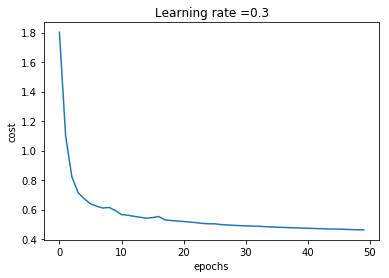

Parameters have been trained!
Train accuracy: 85.6%
Dev accuracy: 85.6%
Test accuracy: 91.6%


In [410]:
# Let's try now a different nn architecture, with 2 hidden layers with 64 nodes each. Adjusted learning rate to 0.3

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 32, 32, Y_train.shape[1]], 
                      learning_rate = 0.3, num_epochs = 50, minibatch_size = 128, print_cost = True)

Note: Train accuracy worsened significantly while dev accuracy only slightly, now matching the same train accuracy level. This indicates good generalization but underfitting

Cost after epoch 0: 5.703082
Cost after epoch 1: 1.578515
Cost after epoch 2: 1.144659
Cost after epoch 3: 0.937617
Cost after epoch 4: 0.814286
Cost after epoch 5: 0.737320
Cost after epoch 6: 0.683787
Cost after epoch 7: 0.637676
Cost after epoch 8: 0.602730
Cost after epoch 9: 0.572667
Cost after epoch 10: 0.553482
Cost after epoch 11: 0.530154
Cost after epoch 12: 0.507685
Cost after epoch 13: 0.492655
Cost after epoch 14: 0.478889
Cost after epoch 15: 0.462445
Cost after epoch 16: 0.450170
Cost after epoch 17: 0.438981
Cost after epoch 18: 0.426893
Cost after epoch 19: 0.413726
Cost after epoch 20: 0.405120
Cost after epoch 21: 0.393208
Cost after epoch 22: 0.385590
Cost after epoch 23: 0.376005
Cost after epoch 24: 0.368319
Cost after epoch 25: 0.359218
Cost after epoch 26: 0.350444
Cost after epoch 27: 0.342320
Cost after epoch 28: 0.333938
Cost after epoch 29: 0.327346
Cost after epoch 30: 0.320506
Cost after epoch 31: 0.312788
Cost after epoch 32: 0.307141
Cost after epoch 33:

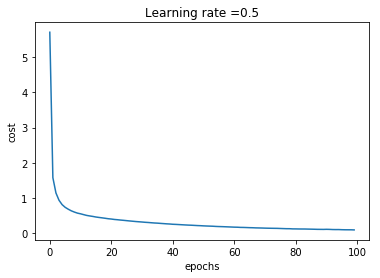

Parameters have been trained!
Train accuracy: 97.3%
Dev accuracy: 87.2%
Test accuracy: 93.2%


In [418]:
# Let's get back to the 1 hidden layer model, now with 256 hidden nodes. Adjusted learnig rate to original value: 0.5

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 256, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: Train accuracy improved significantly (highest value so far) while dev accuracy only slightly, having a wide gap between them. This indicates poor generalization and overfitting

Cost after epoch 0: 10.730956
Cost after epoch 1: 2.767239
Cost after epoch 2: 1.815728
Cost after epoch 3: 1.387284
Cost after epoch 4: 1.112699
Cost after epoch 5: 0.940918
Cost after epoch 6: 0.826081
Cost after epoch 7: 0.748193
Cost after epoch 8: 0.683355
Cost after epoch 9: 0.626883
Cost after epoch 10: 0.583524
Cost after epoch 11: 0.529931
Cost after epoch 12: 0.504122
Cost after epoch 13: 0.472409
Cost after epoch 19: 0.330234
Cost after epoch 20: 0.314598
Cost after epoch 21: 0.300874
Cost after epoch 22: 0.277260
Cost after epoch 23: 0.270458
Cost after epoch 24: 0.254703
Cost after epoch 25: 0.240674
Cost after epoch 26: 0.230573
Cost after epoch 27: 0.220967
Cost after epoch 28: 0.213338
Cost after epoch 29: 0.206951
Cost after epoch 30: 0.195880
Cost after epoch 31: 0.191332
Cost after epoch 32: 0.179438
Cost after epoch 33: 0.172793
Cost after epoch 34: 0.165726
Cost after epoch 35: 0.160065
Cost after epoch 36: 0.157099
Cost after epoch 37: 0.150124
Cost after epoch 38

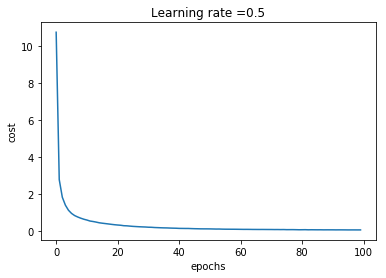

Parameters have been trained!
Train accuracy: 98.9%
Dev accuracy: 87.2%
Test accuracy: 93.0%


In [ ]:
# Let's try now even a bigger nn, with 512 hidden nodes

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 512, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: as expected, train accuracy increased (highest value so far) but dev accuracy stayed at the same level, widering even further the gap. This indicates poor generalization and overfitting

Cost after epoch 0: 21.551738
Cost after epoch 1: 5.194298
Cost after epoch 2: 3.199275
Cost after epoch 3: 2.287248
Cost after epoch 4: 1.755237
Cost after epoch 5: 1.388625
Cost after epoch 6: 1.197134
Cost after epoch 7: 0.980969
Cost after epoch 8: 0.837027
Cost after epoch 9: 0.722353
Cost after epoch 10: 0.630789
Cost after epoch 11: 0.536240
Cost after epoch 12: 0.472118
Cost after epoch 13: 0.434201
Cost after epoch 14: 0.381772
Cost after epoch 15: 0.324994
Cost after epoch 16: 0.294947
Cost after epoch 17: 0.272669
Cost after epoch 18: 0.242927
Cost after epoch 19: 0.222170
Cost after epoch 20: 0.218595
Cost after epoch 21: 0.188100
Cost after epoch 22: 0.172486
Cost after epoch 23: 0.169256
Cost after epoch 24: 0.150445
Cost after epoch 25: 0.145297
Cost after epoch 26: 0.134449
Cost after epoch 27: 0.125806
Cost after epoch 28: 0.119529
Cost after epoch 29: 0.112232
Cost after epoch 30: 0.099929
Cost after epoch 31: 0.096786
Cost after epoch 32: 0.097321
Cost after epoch 33

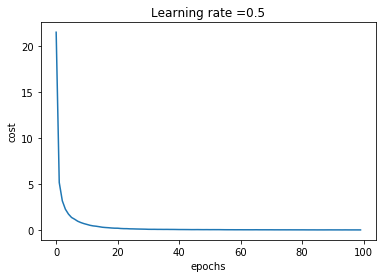

Parameters have been trained!
Train accuracy: 99.4%
Dev accuracy: 87.8%
Test accuracy: 93.8%


In [420]:
#Let's go back to the original nn with 1024 hidden nodes, now with longer training

parameters = dl_model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: as expected, train accuracy increased (highest value so far) but dev accuracy stayed at the same level, widering even further the gap. This indicates poor generalization and overfitting

Now, let's define some helper functions to add L2 regularization to tackle overfitting and improve generalization

In [423]:
def compute_cost_L2_reg(Z, Y, parameters, lambd = 0.0001):
    """
    Computes the cost with L2 regularization
    
    Arguments:
    Z -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, output size)
    Y -- "true" labels vector placeholder, same shape as Z
    parameters -- python dictionary containing tensors "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (layer_dims[l],)
    lambd -- regularization factor
    
    Returns:
    cost - Tensor of the cost function with L2 regularization
    """
    
    L = len(parameters) // 2
    
    x_entr_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    
    L2_reg_cost = tf.add_n([ tf.nn.l2_loss(parameters['W' + str(l)]) for l in range(1, L) ])
    
    cost = x_entr_cost + lambd * L2_reg_cost
    
    return cost

In [424]:
tf.reset_default_graph()
n_x = 12288
n_y = 6
with tf.Session() as sess:
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters([n_x, 30, 10, n_y])
    Z = forward_propagation(X, parameters)
    cost = compute_cost_L2_reg(Z, Y, parameters, lambd = 0.0001)
    print("cost = " + str(cost))

cost = Tensor("add:0", shape=(), dtype=float32)


In [426]:
def dl_model_L2_reg(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, layer_dims, learning_rate = 0.5, lambd = 0.0001,
          num_epochs = 101, minibatch_size = 128, print_cost = True):
    """
    Implements and trains a N-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->...->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- train set, of shape (m, n_x)
    Y_train -- train labels, of shape (m, n_y)
    X_dev -- dev set, of shape (m_dev, n_x)
    Y_dev -- dev labels, of shape (m_dev, n_y)    
    X_test -- test set, of shape (m_test, n_x)
    Y_test -- test labels, of shape (m_test, n_y)
    layer_dims -- python array (list) containing the dimensions of each layer in our network 
    learning_rate -- learning rate of the optimization
    lambd -- L2 regularization factor
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    m = X_train.shape[0]                              # m : number of examples in the train set)
    n_x, n_y = layer_dims[0], layer_dims[-1]          # n_x: input size, n_y : output size
    num_minibatches = int(m / minibatch_size)         # number of minibatches of size minibatch_size in the train set
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y) for training data batches 
    X, Y = create_placeholders(n_x, n_y)
    
    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation(X, parameters)
    
    # Predictions: Add predictions to tensorflow graph
    Y_hat = tf.nn.softmax(Z)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost_L2_reg(Z, Y, parameters, lambd)
    
    # Backpropagation: Define the tensorflow optimizer. Use a GradientDescentOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        batch_cost = 0
        n_minibatch = 0
        
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0.                           # Defines a cost related to an epoch
            seed = seed + 1
            minibatches = random_minibatches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run step
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y})
                # Add minibatch cost to epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                            
            # Print the cost, train accuracy and dev accuracy every 100 minibatches
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate accuracy on the train, dev and test sets
        print("Train accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_train}), Y_train))
        print("Dev accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_dev}), Y_dev))
        print("Test accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_test}), Y_test))
      
    return parameters

Cost after epoch 0: 49.052130
Cost after epoch 1: 27.623847
Cost after epoch 2: 22.023799
Cost after epoch 3: 18.220863
Cost after epoch 4: 15.279078
Cost after epoch 5: 12.908552
Cost after epoch 6: 10.973503
Cost after epoch 7: 9.349926
Cost after epoch 8: 7.991691
Cost after epoch 9: 6.845846
Cost after epoch 10: 5.869958
Cost after epoch 11: 5.041254
Cost after epoch 12: 4.336634
Cost after epoch 13: 3.733589
Cost after epoch 14: 3.221233
Cost after epoch 15: 2.782790
Cost after epoch 16: 2.408542
Cost after epoch 17: 2.088398
Cost after epoch 18: 1.814710
Cost after epoch 19: 1.582004
Cost after epoch 20: 1.383711
Cost after epoch 21: 1.214034
Cost after epoch 22: 1.069185
Cost after epoch 23: 0.947797
Cost after epoch 24: 0.840877
Cost after epoch 25: 0.754568
Cost after epoch 26: 0.678741
Cost after epoch 27: 0.614637
Cost after epoch 28: 0.558116
Cost after epoch 29: 0.511399
Cost after epoch 30: 0.470993
Cost after epoch 31: 0.439168
Cost after epoch 32: 0.409271
Cost after ep

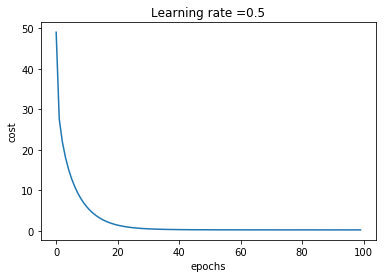

Parameters have been trained!
Train accuracy: 97.0%
Dev accuracy: 90.4%
Test accuracy: 95.3%


In [427]:
# Let's try the same last nn with 1024 hidden nodes and add L2 regularization (lambda = 0.0001)

parameters = dl_model_L2_reg(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, lambd = 0.0001, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: As expected, dev accuracy increased (so did test accuracy) at the expense of train accuracy. Though generalization improved, the gap between train and dev accuracies suggests further room for improvement

Cost after epoch 0: 72.374270
Cost after epoch 1: 40.700025
Cost after epoch 2: 28.539285
Cost after epoch 3: 20.515769
Cost after epoch 4: 14.917758
Cost after epoch 5: 10.915629
Cost after epoch 6: 8.032644
Cost after epoch 7: 5.942362
Cost after epoch 8: 4.420267
Cost after epoch 9: 3.310957
Cost after epoch 10: 2.501198
Cost after epoch 11: 1.910137
Cost after epoch 12: 1.480895
Cost after epoch 13: 1.167694
Cost after epoch 14: 0.938698
Cost after epoch 15: 0.772106
Cost after epoch 16: 0.650802
Cost after epoch 17: 0.562672
Cost after epoch 18: 0.497118
Cost after epoch 19: 0.447706
Cost after epoch 20: 0.412282
Cost after epoch 21: 0.384044
Cost after epoch 22: 0.363677
Cost after epoch 23: 0.348737
Cost after epoch 24: 0.337628
Cost after epoch 25: 0.327432
Cost after epoch 26: 0.319210
Cost after epoch 27: 0.312933
Cost after epoch 28: 0.309586
Cost after epoch 29: 0.305612
Cost after epoch 30: 0.304822
Cost after epoch 31: 0.300467
Cost after epoch 32: 0.299083
Cost after epo

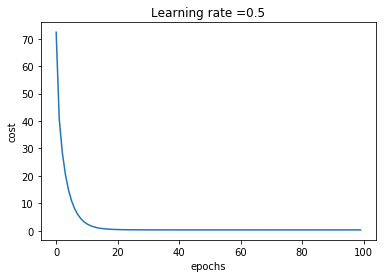

Parameters have been trained!
Train accuracy: 94.9%
Dev accuracy: 89.0%
Test accuracy: 94.8%


In [469]:
# Let's increase L2 regularization factor lambda to boost regularization (lambda = 0.0001 -> 0.0002)

parameters = dl_model_L2_reg(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, lambd = 0.0002, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: Train accuracy decreased as expected but dev accuracy slightly decreased. Though generalization slightly improved, in absolute terms, accuracy worsened

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [434]:
# Let's remove L2 regularization by setting lambd to zero

# L2 regularization for logistic model - Graph setup

batch_size = 128   # Batch size for SGD
learning_rate = 0.5   # Learning rate
lambd = 0   # Regularization factor 0.0001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  Xt = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
  Yt = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
  Xd = tf.constant(X_dev)
  Xs = tf.constant(X_test)

  # Variables.
  W = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  b = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  Zt = tf.matmul(Xt, W) + b
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Yt, logits = Zt))
  l2_cost = lambd * tf.nn.l2_loss(W)
  cost = cost + l2_cost

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
  
  # Predictions for the training, validation, and test data.
  Yt_hat = tf.nn.softmax(Zt)
  Yd_hat = tf.nn.softmax(tf.matmul(Xd, W) + b)
  Ys_hat = tf.nn.softmax(tf.matmul(Xs, W) + b)

In [435]:
# Let's run graph with just a small subset of the training set (1000 examples) to drive overfitting on the training set

num_steps = 3001
train_set_portion_size = 1000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_set_portion_size - batch_size)
    # Generate a minibatch.
    batch_data = X_train[offset:(offset + batch_size), :]
    batch_labels = Y_train[offset:(offset + batch_size), :]
    # Run step
    _, batch_cost_val, Yt_hat_val = session.run([optimizer, cost, Yt_hat], feed_dict = {Xt : batch_data, Yt : batch_labels})
    if (step % 500 == 0):
      print("Minibatch cost at step %d: %f" % (step, batch_cost_val))
      print("Minibatch accuracy: %.1f%%" % accuracy(Yt_hat_val, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(Yd_hat.eval(), Y_dev))
  print("Test accuracy: %.1f%%" % accuracy(Ys_hat.eval(), Y_test))

Initialized
Minibatch cost at step 0: 14.007846
Minibatch accuracy: 19.5%
Validation accuracy: 17.4%
Minibatch cost at step 500: 0.145876
Minibatch accuracy: 97.7%
Validation accuracy: 67.2%
Minibatch cost at step 1000: 0.053320
Minibatch accuracy: 99.2%
Validation accuracy: 67.6%
Minibatch cost at step 1500: 0.030058
Minibatch accuracy: 100.0%
Validation accuracy: 68.0%
Minibatch cost at step 2000: 0.038102
Minibatch accuracy: 100.0%
Validation accuracy: 68.5%
Minibatch cost at step 2500: 0.040022
Minibatch accuracy: 99.2%
Validation accuracy: 68.8%
Minibatch cost at step 3000: 0.012993
Minibatch accuracy: 100.0%
Validation accuracy: 69.1%
Test accuracy: 77.1%


Note: as expected, the logistic regression model is overfitting the small train set achieving a maximum train accuracy of 100%, while generalization is very poor, as validation accuracy of 69% indicates 

In [438]:
# Let's now add L2 regularization

# L2 regularization for logistic model - Graph setup

batch_size = 128   # Batch size for SGD
learning_rate = 0.5   # Learning rate
lambd = 0.01   # Regularization factor 0.01

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  Xt = tf.placeholder(tf.float32, shape = (batch_size, image_size * image_size))
  Yt = tf.placeholder(tf.float32, shape = (batch_size, num_labels))
  Xd = tf.constant(X_dev)
  Xs = tf.constant(X_test)

  # Variables.
  W = tf.Variable(tf.truncated_normal([image_size * image_size, num_labels]))
  b = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  Zt = tf.matmul(Xt, W) + b
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Yt, logits = Zt))
  l2_cost = lambd * tf.nn.l2_loss(W)
  cost = cost + l2_cost

  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
  
  # Predictions for the training, validation, and test data.
  Yt_hat = tf.nn.softmax(Zt)
  Yd_hat = tf.nn.softmax(tf.matmul(Xd, W) + b)
  Ys_hat = tf.nn.softmax(tf.matmul(Xs, W) + b)

In [439]:
# Let's run graph with just a small subset of the training set (1000 examples) to drive overfitting on the training set

num_steps = 3001
train_set_portion_size = 1000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_set_portion_size - batch_size)
    # Generate a minibatch.
    batch_data = X_train[offset:(offset + batch_size), :]
    batch_labels = Y_train[offset:(offset + batch_size), :]
    # Run step
    _, batch_cost_val, Yt_hat_val = session.run([optimizer, cost, Yt_hat], feed_dict = {Xt : batch_data, Yt : batch_labels})
    if (step % 500 == 0):
      print("Minibatch cost at step %d: %f" % (step, batch_cost_val))
      print("Minibatch accuracy: %.1f%%" % accuracy(Yt_hat_val, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(Yd_hat.eval(), Y_dev))
  print("Test accuracy: %.1f%%" % accuracy(Ys_hat.eval(), Y_test))

Initialized
Minibatch cost at step 0: 46.618317
Minibatch accuracy: 10.2%
Validation accuracy: 13.3%
Minibatch cost at step 500: 0.634213
Minibatch accuracy: 94.5%
Validation accuracy: 77.1%
Minibatch cost at step 1000: 0.503900
Minibatch accuracy: 93.8%
Validation accuracy: 77.5%
Minibatch cost at step 1500: 0.443488
Minibatch accuracy: 97.7%
Validation accuracy: 77.5%
Minibatch cost at step 2000: 0.583283
Minibatch accuracy: 92.2%
Validation accuracy: 77.4%
Minibatch cost at step 2500: 0.623026
Minibatch accuracy: 89.8%
Validation accuracy: 76.6%
Minibatch cost at step 3000: 0.441115
Minibatch accuracy: 95.3%
Validation accuracy: 77.6%
Test accuracy: 84.9%


Note: as expected, with L2 regularization, generalization improves, as the gap between train accuracy and validation accuracy diminishes. The gap is still wide suggesting further room for improvement

Let's experiment the overfitting issue with nn model

Cost after epoch 0: 629.650796
Cost after epoch 1: 143.547831
Cost after epoch 2: 43.469157
Cost after epoch 3: 50.442812
Cost after epoch 4: 41.314054
Cost after epoch 5: 30.417358
Cost after epoch 6: 20.387416
Cost after epoch 7: 9.620776
Cost after epoch 8: 8.872062
Cost after epoch 9: 5.658569
Cost after epoch 10: 3.826663
Cost after epoch 11: 5.960957
Cost after epoch 12: 7.616385
Cost after epoch 13: 5.555296
Cost after epoch 14: 3.102347
Cost after epoch 15: 3.799143
Cost after epoch 16: 6.934374
Cost after epoch 17: 3.509900
Cost after epoch 18: 4.069808
Cost after epoch 19: 2.816133
Cost after epoch 20: 2.812919
Cost after epoch 21: 4.832503
Cost after epoch 22: 4.212261
Cost after epoch 23: 3.322075
Cost after epoch 24: 14.322317
Cost after epoch 25: 3.382982
Cost after epoch 26: 4.062805
Cost after epoch 27: 1.106255
Cost after epoch 28: 1.245495
Cost after epoch 29: 0.885705
Cost after epoch 30: 1.230217
Cost after epoch 31: 0.970745
Cost after epoch 32: 0.374452
Cost after

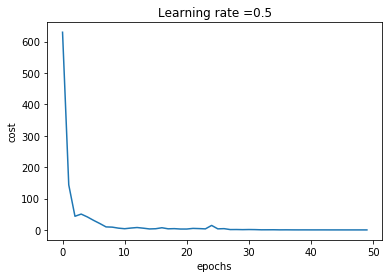

Parameters have been trained!
Train accuracy: 99.9%
Dev accuracy: 76.9%
Test accuracy: 84.7%


In [450]:
# Let's try the nn model trained on a subset of the training set (1000 examples) to force overfitting on training
# First, with no regularization

parameters = dl_model_L2_reg(X_train[:1000, :], Y_train[:1000, :], X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, lambd = 0, num_epochs = 50, minibatch_size = 32, print_cost = True)

Note: as expected, the neural network model is overfitting the small train set achieving a maximum train accuracy of ca. 100%, while generalization is considerably poor, as dev accuracy of 77% indicates

Cost after epoch 0: 1569.134929
Cost after epoch 1: 979.410780
Cost after epoch 2: 812.583973
Cost after epoch 3: 734.535645
Cost after epoch 4: 661.243798
Cost after epoch 5: 594.716948
Cost after epoch 6: 538.853029
Cost after epoch 7: 486.611584
Cost after epoch 8: 441.948666
Cost after epoch 9: 404.444428
Cost after epoch 10: 366.140625
Cost after epoch 11: 337.919486
Cost after epoch 12: 306.380641
Cost after epoch 13: 281.588412
Cost after epoch 14: 259.953603
Cost after epoch 15: 233.881876
Cost after epoch 16: 212.504021
Cost after epoch 17: 192.399554
Cost after epoch 18: 174.589230
Cost after epoch 19: 161.244538
Cost after epoch 20: 158.791933
Cost after epoch 21: 143.192727
Cost after epoch 22: 151.481637
Cost after epoch 23: 122.773046
Cost after epoch 24: 142.268684
Cost after epoch 25: 103.517258
Cost after epoch 26: 95.014713
Cost after epoch 27: 83.631773
Cost after epoch 28: 75.358259
Cost after epoch 29: 70.015432
Cost after epoch 30: 63.054884
Cost after epoch 31: 5

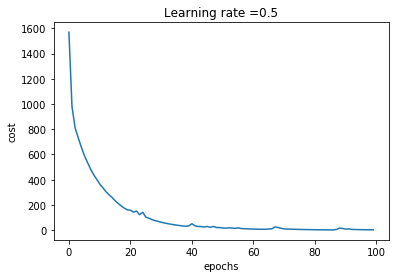

Parameters have been trained!
Train accuracy: 99.8%
Dev accuracy: 78.1%
Test accuracy: 85.6%


In [468]:
# Let's try the nn model trained on a subset of the training set (1000 examples) to force overfitting on training
# Now, with L2 regularization

parameters = dl_model_L2_reg(X_train[:1000, :], Y_train[:1000, :], X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, lambd = 0.003, num_epochs = 100, minibatch_size = 32, print_cost = True)

Note: as expected, with L2 regularization, generalization improves (though not significantly), as the gap between train accuracy and validation accuracy diminishes. The gap is still wide suggesting further room for improvement

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

Let's first define some helper functions to add dropout to tackle overfitting and improve generalization

In [473]:
def forward_propagation_dropout(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model
    
    Arguments:
    X -- input dataset placeholder, of shape (number of examples, input size)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    keep_prob -- dropout keep probability placeholder

    Returns:
    Z -- the output of the last LINEAR unit
    """
    
    L = len(parameters) // 2
    A = X
    
    for l in range(1, L):
      Z = tf.add(tf.matmul(tf.nn.dropout(A, keep_prob), parameters['W' + str(l)]), parameters['b' + str(l)])
      A = tf.nn.relu(Z)
    
    Z = tf.add(tf.matmul(tf.nn.dropout(A, keep_prob), parameters['W' + str(L)]), parameters['b' + str(L)])

    return Z

In [476]:
# Try forward_propagation function

tf.reset_default_graph()
n_x = 12228
n_y = 6
with tf.Session() as sess:
    X, Y = create_placeholders(n_x, n_y)
    parameters = initialize_parameters([n_x, 30, 10, n_y])
    Z = forward_propagation_dropout(X, parameters, keep_prob = 0.8)
    print("Z = " + str(Z))

Z = Tensor("Add_2:0", shape=(?, 6), dtype=float32)


In [478]:
def dl_model_dropout(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, layer_dims, learning_rate = 0.5, keep_prob_val = 0.7,
          num_epochs = 101, minibatch_size = 128, print_cost = True):
    """
    Implements and trains a N-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->...->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- train set, of shape (m, n_x)
    Y_train -- train labels, of shape (m, n_y)
    X_dev -- dev set, of shape (m_dev, n_x)
    Y_dev -- dev labels, of shape (m_dev, n_y)    
    X_test -- test set, of shape (m_test, n_x)
    Y_test -- test labels, of shape (m_test, n_y)
    layer_dims -- python array (list) containing the dimensions of each layer in our network 
    learning_rate -- learning rate of the optimization
    keep_prob_val -- dropout keep probability value
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    m = X_train.shape[0]                              # m : number of examples in the train set)
    n_x, n_y = layer_dims[0], layer_dims[-1]          # n_x: input size, n_y : output size
    num_minibatches = int(m / minibatch_size)         # number of minibatches of size minibatch_size in the train set
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y) for training data batches 
    X, Y = create_placeholders(n_x, n_y)
    
    # Create Placeholder for keep_prob
    keep_prob = tf.placeholder(tf.float32)
    
    # Initialize parameters
    parameters = initialize_parameters(layer_dims)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation_dropout(X, parameters, keep_prob)
    
    # Predictions: Add predictions to tensorflow graph
    Y_hat = tf.nn.softmax(Z)
   
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use a GradientDescentOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        batch_cost = 0
        n_minibatch = 0
        
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0.                           # Defines a cost related to an epoch
            seed = seed + 1
            minibatches = random_minibatches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run step
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y, keep_prob : keep_prob_val})
                # Add minibatch cost to epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                            
            # Print the cost, train accuracy and dev accuracy every 100 minibatches
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate accuracy on the train, dev and test sets
        print("Train accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_train, keep_prob : 1.0}), Y_train))
        print("Dev accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_dev, keep_prob : 1.0}), Y_dev))
        print("Test accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_test, keep_prob : 1.0}), Y_test))
      
    return parameters

Cost after epoch 0: 385.497964
Cost after epoch 1: 245.389000
Cost after epoch 2: 201.873474
Cost after epoch 3: 178.089723
Cost after epoch 4: 181.570910
Cost after epoch 5: 167.393466
Cost after epoch 6: 134.989823
Cost after epoch 7: 142.278011
Cost after epoch 8: 131.443913
Cost after epoch 9: 125.380029
Cost after epoch 10: 115.101392
Cost after epoch 11: 115.794713
Cost after epoch 12: 102.258852
Cost after epoch 13: 107.827588
Cost after epoch 14: 104.150345
Cost after epoch 15: 95.269321
Cost after epoch 16: 89.945671
Cost after epoch 17: 94.103445
Cost after epoch 18: 90.258517
Cost after epoch 19: 85.973109
Cost after epoch 20: 75.496729
Cost after epoch 21: 77.686331
Cost after epoch 22: 78.582900
Cost after epoch 23: 83.439636
Cost after epoch 24: 82.402377
Cost after epoch 25: 73.164554
Cost after epoch 26: 76.618947
Cost after epoch 27: 61.906654
Cost after epoch 28: 59.510524
Cost after epoch 29: 68.761203
Cost after epoch 30: 67.200677
Cost after epoch 31: 51.971323
Cos

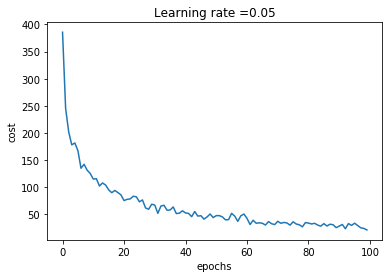

Parameters have been trained!
Train accuracy: 99.5%
Dev accuracy: 79.4%
Test accuracy: 86.9%


In [484]:
# Let's try the nn model trained on a subset of the training set (1000 examples) to force overfitting on training
# Now, with dropout

parameters = dl_model_dropout(X_train[:1000, :], Y_train[:1000, :], X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.05, keep_prob_val = 0.5, num_epochs = 100, minibatch_size = 32, print_cost = True)

Note: as expected, with dropout, generalization improves (though not significantly), as the gap between train accuracy and validation accuracy diminishes. The gap is still wide suggesting further room for improvement. With the chosen hyperparameters, same training, we have achieved slightly better results with dropout than with L2 regularization

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, global_step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


Cost after epoch 0: 52.945131
Cost after epoch 1: 20.420201
Cost after epoch 2: 12.877766
Cost after epoch 3: 9.365502
Cost after epoch 4: 7.038470
Cost after epoch 5: 5.567130
Cost after epoch 6: 4.552555
Cost after epoch 7: 3.731123
Cost after epoch 8: 3.352019
Cost after epoch 9: 2.946972
Cost after epoch 10: 2.597058
Cost after epoch 11: 2.349213
Cost after epoch 12: 2.173816
Cost after epoch 13: 1.960958
Cost after epoch 14: 1.803012
Cost after epoch 15: 1.706948
Cost after epoch 16: 1.589801
Cost after epoch 17: 1.508414
Cost after epoch 18: 1.428373
Cost after epoch 19: 1.367731
Cost after epoch 20: 1.312817
Cost after epoch 21: 1.257147
Cost after epoch 22: 1.215568
Cost after epoch 23: 1.166573
Cost after epoch 24: 1.140084
Cost after epoch 25: 1.094917
Cost after epoch 26: 1.073360
Cost after epoch 27: 1.027288
Cost after epoch 28: 1.006479
Cost after epoch 29: 0.980639
Cost after epoch 30: 0.951545
Cost after epoch 31: 0.937046
Cost after epoch 32: 0.931140
Cost after epoch 

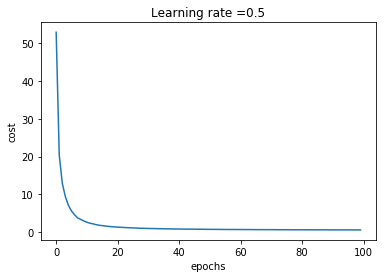

Parameters have been trained!
Train accuracy: 87.4%
Dev accuracy: 86.5%
Test accuracy: 92.5%


In [491]:
# Let's start with the original nn with 1024 hidden units, adding dropout with keep_prob = 0.7

parameters = dl_model_dropout(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, keep_prob_val = 0.7, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: Train and dev accuracies are roughly at the same level ca 87% (though lower than previous accuracies achieved with L2 regularization), indicating good generalization, but some underfitting

Cost after epoch 0: 28.258079
Cost after epoch 1: 8.604738
Cost after epoch 2: 5.519577
Cost after epoch 3: 4.009693
Cost after epoch 4: 3.150596
Cost after epoch 5: 2.635743
Cost after epoch 6: 2.199263
Cost after epoch 7: 1.960274
Cost after epoch 8: 1.736181
Cost after epoch 9: 1.563740
Cost after epoch 10: 1.423834
Cost after epoch 11: 1.283604
Cost after epoch 12: 1.212593
Cost after epoch 13: 1.126584
Cost after epoch 14: 1.076048
Cost after epoch 15: 0.999268
Cost after epoch 16: 0.956101
Cost after epoch 17: 0.913004
Cost after epoch 18: 0.871368
Cost after epoch 19: 0.829877
Cost after epoch 20: 0.805897
Cost after epoch 21: 0.789320
Cost after epoch 22: 0.756889
Cost after epoch 23: 0.741896
Cost after epoch 24: 0.708226
Cost after epoch 25: 0.695861
Cost after epoch 26: 0.677257
Cost after epoch 27: 0.676863
Cost after epoch 28: 0.658015
Cost after epoch 29: 0.641632
Cost after epoch 30: 0.627207
Cost after epoch 31: 0.608725
Cost after epoch 32: 0.598284
Cost after epoch 33

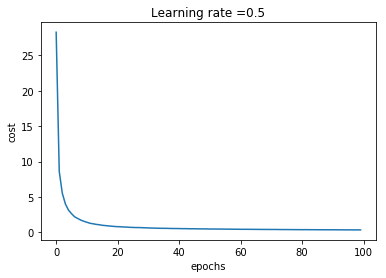

Parameters have been trained!
Train accuracy: 93.4%
Dev accuracy: 88.5%
Test accuracy: 94.0%


In [492]:
# Let's increase keep_prob to 0.9 to reduce dropout

parameters = dl_model_dropout(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, keep_prob_val = 0.9, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: Both train and dev accuracies have gone up (though still below accuracies achieved with L2 regularization), but gap between them widened. This indicates we start overfitting and worsening generalization

Cost after epoch 0: 24.496641
Cost after epoch 1: 6.719584
Cost after epoch 2: 4.256590
Cost after epoch 3: 3.120860
Cost after epoch 4: 2.425947
Cost after epoch 5: 2.056193
Cost after epoch 6: 1.743055
Cost after epoch 7: 1.499673
Cost after epoch 8: 1.337397
Cost after epoch 9: 1.215157
Cost after epoch 10: 1.096620
Cost after epoch 11: 1.000186
Cost after epoch 12: 0.937783
Cost after epoch 13: 0.879485
Cost after epoch 14: 0.828258
Cost after epoch 15: 0.761182
Cost after epoch 16: 0.733135
Cost after epoch 17: 0.702000
Cost after epoch 18: 0.671118
Cost after epoch 19: 0.638213
Cost after epoch 20: 0.613103
Cost after epoch 21: 0.598284
Cost after epoch 22: 0.581438
Cost after epoch 23: 0.555671
Cost after epoch 24: 0.546517
Cost after epoch 25: 0.533833
Cost after epoch 26: 0.506133
Cost after epoch 27: 0.503971
Cost after epoch 28: 0.483070
Cost after epoch 29: 0.475103
Cost after epoch 30: 0.455246
Cost after epoch 31: 0.451589
Cost after epoch 32: 0.441718
Cost after epoch 33

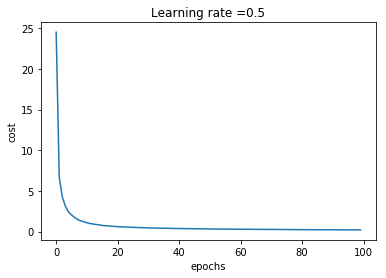

Parameters have been trained!
Train accuracy: 96.8%
Dev accuracy: 89.2%
Test accuracy: 94.5%


In [493]:
# Let's increase a bit more keep_prob to 0.95 to reduce even further dropout

parameters = dl_model_dropout(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, Y_train.shape[1]], 
                      learning_rate = 0.5, keep_prob_val = 0.95, num_epochs = 100, minibatch_size = 128, print_cost = True)

Note: Again, both train and dev accuracies have gone up (and got very close to accuracies achieved with L2 regularization) and,  as expected, gap between them widened even further

It seems we have reached some accuracy limits with the current nn, so we are going to try deeper networks, with 2 and 3 hidden layers

First, we will update the initialize_parameters function to follow Andrew Ng's guidance on weight initialization for nn. Note: I have tried deeper networks with the original initialize_parameters function and could not improve accuracy

In [494]:
def initialize_parameters_n(layer_dims):
    """
    Initializes parameters to build a neural network with tensorflow
    
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    variables -- python dictionary containing tensors "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (layer_dims[l],)
    """
    
    tf.set_random_seed(1)                   # so to keep consistent results
        
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = tf.Variable(tf.random_normal([layer_dims[l-1], layer_dims[l]], stddev = np.sqrt(2 / layer_dims[l-1])), name = 'W' + str(l))
        parameters['b' + str(l)] = tf.Variable(tf.zeros([layer_dims[l]]), name = 'b' + str(l))
        
        assert(parameters['W' + str(l)].get_shape().as_list() == [layer_dims[l-1], layer_dims[l]])
        assert(parameters['b' + str(l)].get_shape().as_list() == [layer_dims[l]])

    return parameters  

In [497]:
# Try initialize_parameters function

tf.reset_default_graph()
parameters = initialize_parameters_n([5,4,3])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = Tensor("W1/read:0", shape=(5, 4), dtype=float32)
b1 = Tensor("b1/read:0", shape=(4,), dtype=float32)
W2 = Tensor("W2/read:0", shape=(4, 3), dtype=float32)
b2 = Tensor("b2/read:0", shape=(3,), dtype=float32)


In [498]:
def dl_model_dropout_n(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, layer_dims, learning_rate = 0.5, keep_prob_val = 0.7,
          num_epochs = 101, minibatch_size = 128, print_cost = True):
    """
    Implements and trains a N-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->...->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- train set, of shape (m, n_x)
    Y_train -- train labels, of shape (m, n_y)
    X_dev -- dev set, of shape (m_dev, n_x)
    Y_dev -- dev labels, of shape (m_dev, n_y)    
    X_test -- test set, of shape (m_test, n_x)
    Y_test -- test labels, of shape (m_test, n_y)
    layer_dims -- python array (list) containing the dimensions of each layer in our network 
    learning_rate -- learning rate of the optimization
    keep_prob_val -- dropout keep probability value
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every epoch
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    tf.reset_default_graph()
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    m = X_train.shape[0]                              # m : number of examples in the train set)
    n_x, n_y = layer_dims[0], layer_dims[-1]          # n_x: input size, n_y : output size
    num_minibatches = int(m / minibatch_size)         # number of minibatches of size minibatch_size in the train set
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y) for training data batches 
    X, Y = create_placeholders(n_x, n_y)
    
    # Create Placeholder for keep_prob
    keep_prob = tf.placeholder(tf.float32)
    
    # Initialize parameters
    parameters = initialize_parameters_n(layer_dims)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z = forward_propagation_dropout(X, parameters, keep_prob)
    
    # Predictions: Add predictions to tensorflow graph
    Y_hat = tf.nn.softmax(Z)
   
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use a GradientDescentOptimizer.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        batch_cost = 0
        n_minibatch = 0
        
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0.                           # Defines a cost related to an epoch
            seed = seed + 1
            minibatches = random_minibatches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Run step
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = {X : minibatch_X, Y : minibatch_Y, keep_prob : keep_prob_val})
                # Add minibatch cost to epoch cost
                epoch_cost += minibatch_cost / num_minibatches
                            
            # Print the cost, train accuracy and dev accuracy every 100 minibatches
            if print_cost == True:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('epochs')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate accuracy on the train, dev and test sets
        print("Train accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_train, keep_prob : 1.0}), Y_train))
        print("Dev accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_dev, keep_prob : 1.0}), Y_dev))
        print("Test accuracy: %.1f%%" % accuracy(Y_hat.eval({X : X_test, keep_prob : 1.0}), Y_test))
      
    return parameters

Cost after epoch 0: 0.546643
Cost after epoch 1: 0.431025
Cost after epoch 2: 0.387420
Cost after epoch 3: 0.359873
Cost after epoch 4: 0.337841
Cost after epoch 5: 0.320671
Cost after epoch 6: 0.305118
Cost after epoch 7: 0.291096
Cost after epoch 8: 0.280076
Cost after epoch 9: 0.268931


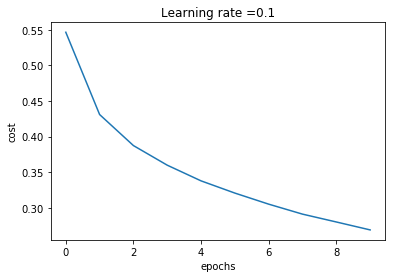

Parameters have been trained!
Train accuracy: 93.5%
Dev accuracy: 91.0%
Test accuracy: 96.0%


In [506]:
# Let's try a nn with 2 hidden layers, first with 1024 nodes and second with 256 nodes, dropout with keep_prob = 0.9

parameters = dl_model_dropout_n(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, 256, Y_train.shape[1]], 
                      learning_rate = 0.1, keep_prob_val = 0.9, num_epochs = 10, minibatch_size = 128, print_cost = True)

Note: Significantly improved train and dev accuracies (highest so far), compared with nn with one hidden layer

Cost after epoch 0: 0.546643
Cost after epoch 1: 0.431025
Cost after epoch 2: 0.387420
Cost after epoch 3: 0.359873
Cost after epoch 4: 0.337841
Cost after epoch 5: 0.320671
Cost after epoch 6: 0.305118
Cost after epoch 7: 0.291096
Cost after epoch 8: 0.280076
Cost after epoch 9: 0.268931
Cost after epoch 10: 0.258408
Cost after epoch 11: 0.249486
Cost after epoch 12: 0.240610
Cost after epoch 13: 0.232741
Cost after epoch 14: 0.223325
Cost after epoch 15: 0.216380
Cost after epoch 16: 0.210447
Cost after epoch 17: 0.203433
Cost after epoch 18: 0.196183
Cost after epoch 19: 0.190826
Cost after epoch 20: 0.185050
Cost after epoch 21: 0.178918
Cost after epoch 22: 0.173439
Cost after epoch 23: 0.169200
Cost after epoch 24: 0.163539
Cost after epoch 25: 0.159327
Cost after epoch 26: 0.154810
Cost after epoch 27: 0.150783
Cost after epoch 28: 0.146697
Cost after epoch 29: 0.144031


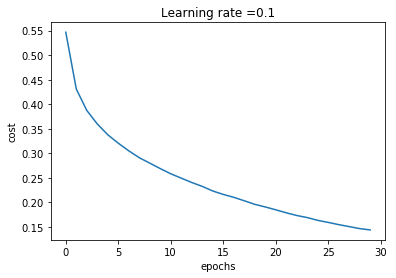

Parameters have been trained!
Train accuracy: 98.0%
Dev accuracy: 92.0%
Test accuracy: 96.7%


In [500]:
# Let's train the same model longer by increasing num_epochs to 30

parameters = dl_model_dropout_n(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, 256, Y_train.shape[1]], 
                      learning_rate = 0.1, keep_prob_val = 0.9, num_epochs = 30, minibatch_size = 128, print_cost = True)

Note: as expected, train accuracy increased, and so dev accuracy though in a lesser proportion, widening the gap between train and dev accuracies. This suggests we start overfitting

Cost after epoch 0: 0.593174
Cost after epoch 1: 0.477894
Cost after epoch 2: 0.437717
Cost after epoch 3: 0.411419
Cost after epoch 4: 0.393107
Cost after epoch 5: 0.376947
Cost after epoch 6: 0.363966
Cost after epoch 7: 0.352388
Cost after epoch 8: 0.343413
Cost after epoch 9: 0.333588
Cost after epoch 10: 0.325507
Cost after epoch 11: 0.318243
Cost after epoch 12: 0.312056
Cost after epoch 13: 0.306546
Cost after epoch 14: 0.298677
Cost after epoch 15: 0.294497
Cost after epoch 16: 0.290483
Cost after epoch 17: 0.284635
Cost after epoch 18: 0.279803
Cost after epoch 19: 0.274819
Cost after epoch 20: 0.271465
Cost after epoch 21: 0.266563
Cost after epoch 22: 0.262813
Cost after epoch 23: 0.259271
Cost after epoch 24: 0.254767
Cost after epoch 25: 0.251429
Cost after epoch 26: 0.248527
Cost after epoch 27: 0.244584
Cost after epoch 28: 0.242230
Cost after epoch 29: 0.238358


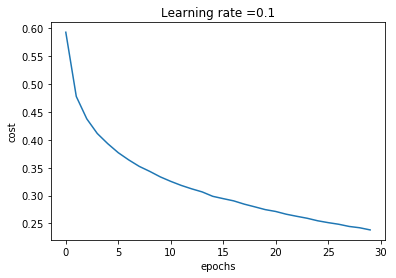

Parameters have been trained!
Train accuracy: 95.2%
Dev accuracy: 91.8%
Test accuracy: 96.6%


In [501]:
# Let's decrease keep_prob value to mitigate overfitting and improve generalization

parameters = dl_model_dropout_n(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, 256, Y_train.shape[1]], 
                      learning_rate = 0.1, keep_prob_val = 0.8, num_epochs = 30, minibatch_size = 128, print_cost = True)

Note: while we have reduced the gap between train and dev accuracies, dev accuracy has gone down slightly, just below 92%

Cost after epoch 0: 0.558310
Cost after epoch 1: 0.439645
Cost after epoch 2: 0.398109
Cost after epoch 3: 0.369557
Cost after epoch 4: 0.348495
Cost after epoch 5: 0.330649
Cost after epoch 6: 0.316616
Cost after epoch 7: 0.303233
Cost after epoch 8: 0.292922
Cost after epoch 9: 0.281002
Cost after epoch 10: 0.272378
Cost after epoch 11: 0.264549
Cost after epoch 12: 0.254601
Cost after epoch 13: 0.246890
Cost after epoch 14: 0.241884
Cost after epoch 15: 0.232474
Cost after epoch 16: 0.228999
Cost after epoch 17: 0.222149
Cost after epoch 18: 0.215724
Cost after epoch 19: 0.210826
Cost after epoch 20: 0.206017
Cost after epoch 21: 0.201093
Cost after epoch 22: 0.197012
Cost after epoch 23: 0.192230
Cost after epoch 24: 0.187584
Cost after epoch 25: 0.185155
Cost after epoch 26: 0.178678
Cost after epoch 27: 0.174847
Cost after epoch 28: 0.172677
Cost after epoch 29: 0.168645
Cost after epoch 30: 0.165700
Cost after epoch 31: 0.160906
Cost after epoch 32: 0.158174
Cost after epoch 33:

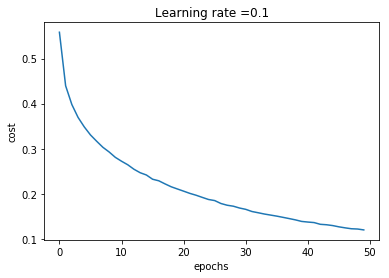

Parameters have been trained!
Train accuracy: 98.4%
Dev accuracy: 92.1%
Test accuracy: 96.7%


In [505]:
# Let's try now a nn with 3 hidden layers with 1024, 256 and 64 nodes, dropout with keep_prob = 0.9

parameters = dl_model_dropout_n(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, 256, 64, Y_train.shape[1]], 
                      learning_rate = 0.1, keep_prob_val = 0.9, num_epochs = 50, minibatch_size = 128, print_cost = True)

Note: we have improved both train and dev accuracies (highest so far), but the gap between train and dev accuracies suggest room for improvement

Cost after epoch 0: 0.556951
Cost after epoch 1: 0.443422
Cost after epoch 2: 0.400926
Cost after epoch 3: 0.375232
Cost after epoch 4: 0.353893
Cost after epoch 5: 0.338666
Cost after epoch 6: 0.325284
Cost after epoch 7: 0.314518
Cost after epoch 8: 0.304519
Cost after epoch 9: 0.295632
Cost after epoch 10: 0.287222
Cost after epoch 11: 0.279407
Cost after epoch 12: 0.272766
Cost after epoch 13: 0.266286
Cost after epoch 14: 0.260449
Cost after epoch 15: 0.254256
Cost after epoch 16: 0.249639
Cost after epoch 17: 0.244864
Cost after epoch 18: 0.240013
Cost after epoch 19: 0.236455
Cost after epoch 20: 0.233700
Cost after epoch 21: 0.226849
Cost after epoch 22: 0.224807
Cost after epoch 23: 0.220142
Cost after epoch 24: 0.216925
Cost after epoch 25: 0.213812
Cost after epoch 26: 0.211106
Cost after epoch 27: 0.206263
Cost after epoch 28: 0.204913
Cost after epoch 29: 0.201039
Cost after epoch 30: 0.201461
Cost after epoch 31: 0.196479
Cost after epoch 32: 0.194381
Cost after epoch 33:

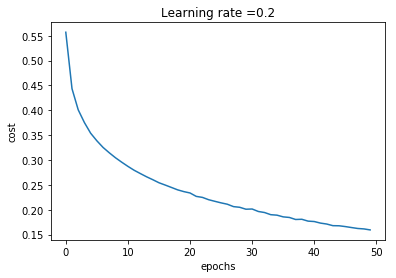

Parameters have been trained!
Train accuracy: 97.3%
Dev accuracy: 91.8%
Test accuracy: 96.6%


In [508]:
# Let's try finally the same nn with 3 hidden layers, increasing dropout, with keep_prob = 0.85, and adjusting learning_rate = 0.2

parameters = dl_model_dropout_n(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, [X_train.shape[1], 1024, 256, 64, Y_train.shape[1]], 
                      learning_rate = 0.2, keep_prob_val = 0.85, num_epochs = 50, minibatch_size = 128, print_cost = True)